## The dataset and packages

You can find the data used in this project here: https://www.kaggle.com/datasnaek/chess version 1. The dataset containsaround 20000 records and 16 variables. The original kaggle poster took these data from Lichess.org using their API. We will mostly use Python's data packages (pandas, sci-kit, etc.). Otherwise, I will be using my own python module (ChessUtility) that will contain more complex code. As I use packages, I will import them.

In [1]:
import pandas as pd
import ChessUtility as cu

Here we can see a small random portion of the data. 

In [2]:
games = pd.read_csv('games.csv')

In [3]:
NUMROWS = 2
cu.sample_entries(games, NUMROWS, games.columns)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
1502,iG3eQIg5,True,1.496420e+12,1.496420e+12,88,mate,black,10+0,guilis,1381,hasan_al-banna,1393,Nf3 Nc6 e3 d5 c4 d4 e4 e5 d3 Bg4 Be2 Nf6 Ng5 B...,A04,Zukertort Opening: Black Mustang Defense,2
10986,6NS6uVXt,False,1.395452e+12,1.395453e+12,47,mate,white,5+8,unzval,1426,delson,1458,d4 d5 c4 e6 Nf3 Nf6 Nc3 c5 cxd5 Nxd5 e4 Nxc3 b...,D41,Queen's Gambit Declined: Semi-Tarrasch | San ...,18


## The predictive question

After looking at the data, I thought it'd be cool to find out how the the difference between two chess ratings relates to the probability of winning for each player. 

For example, suppose that we both meet to play a chess match. I, having been a decent player, have a rating of 1800. You just started playing the other day so you have a rating of 1000. The idea behind a rating is to let us know that we are not evently matched. Given my rating, you should know that I will probably crush you, and your chance of winning is dismally lower than mine.

So, is it possible to quantify this probability and use it to predict who will win a chess match? And, is it possible to quantify the probability of not just losing but also drawing a game?

## Cooking new variables

To answer my predictive question, I made new variables to work with. 

In [4]:
import numpy as np

1) diff_rating will quantify the difference between the player ratings.

In [5]:
games['diff_rating'] = games.white_rating - games.black_rating

2) abs_diff_rating will simply take the absolute value of the quantity above.

In [6]:
games['abs_diff_rating'] = np.abs(games['diff_rating'])

3) higher_rating_won will be a binary variable taking 1 if the person with the higher rating won, and 0 if they didn't.

In [7]:
# To make higher_rating_won, I first make a variable that determines who won - white or black, or if the match was a draw. 
games['higher_rating'] = ''
games.loc[games.diff_rating > 0, 'higher_rating'] = 'white'
games.loc[games.diff_rating < 0, 'higher_rating'] = 'black'
games.loc[games.diff_rating == 0, 'higher_rating'] = 'same'

In [8]:
games['higher_rating_won'] = 0
games.loc[games.winner == games.higher_rating, 'higher_rating_won'] = 1

4) result will encode wether the higher rated player lost, tied, or won (0, 1, 2). 

In [9]:
games['result'] = 0
games.loc[games.winner == 'draw' , 'result'] = 1
games.loc[games.higher_rating_won == 1, 'result'] = 2

5) white_higher_rated encodes whether the higher rated player was white or not (1, 0). 

In [10]:
games['white_higher_rated'] = 0
games.loc[games.higher_rating == 'white', 'white_higher_rated'] = 1

Here's a look at a random sample of our data set for the variables we created. 

In [11]:
made_variables = ['higher_rating', 'diff_rating', 
                            'abs_diff_rating', 'higher_rating_won', 'winner',
                           'result', 'white_higher_rated']
cu.sample_entries(games, NUMROWS, made_variables)

,higher_rating,diff_rating,abs_diff_rating,higher_rating_won,winner,result,white_higher_rated
1114,black,-278,278,1,black,2,0
11662,black,-116,116,0,draw,1,0


Since each call to sample_entries is random, you can run the cell above repeatedly to get different samples from the dataset.

I then save this modified version of the dataset. 

In [12]:
games.to_csv('games_new_vars.csv')

## Missing values check

Before continuing, we will check for missing values in the set. 

In [13]:
import matplotlib.pyplot as plt
import missingno as msn 

%matplotlib inline

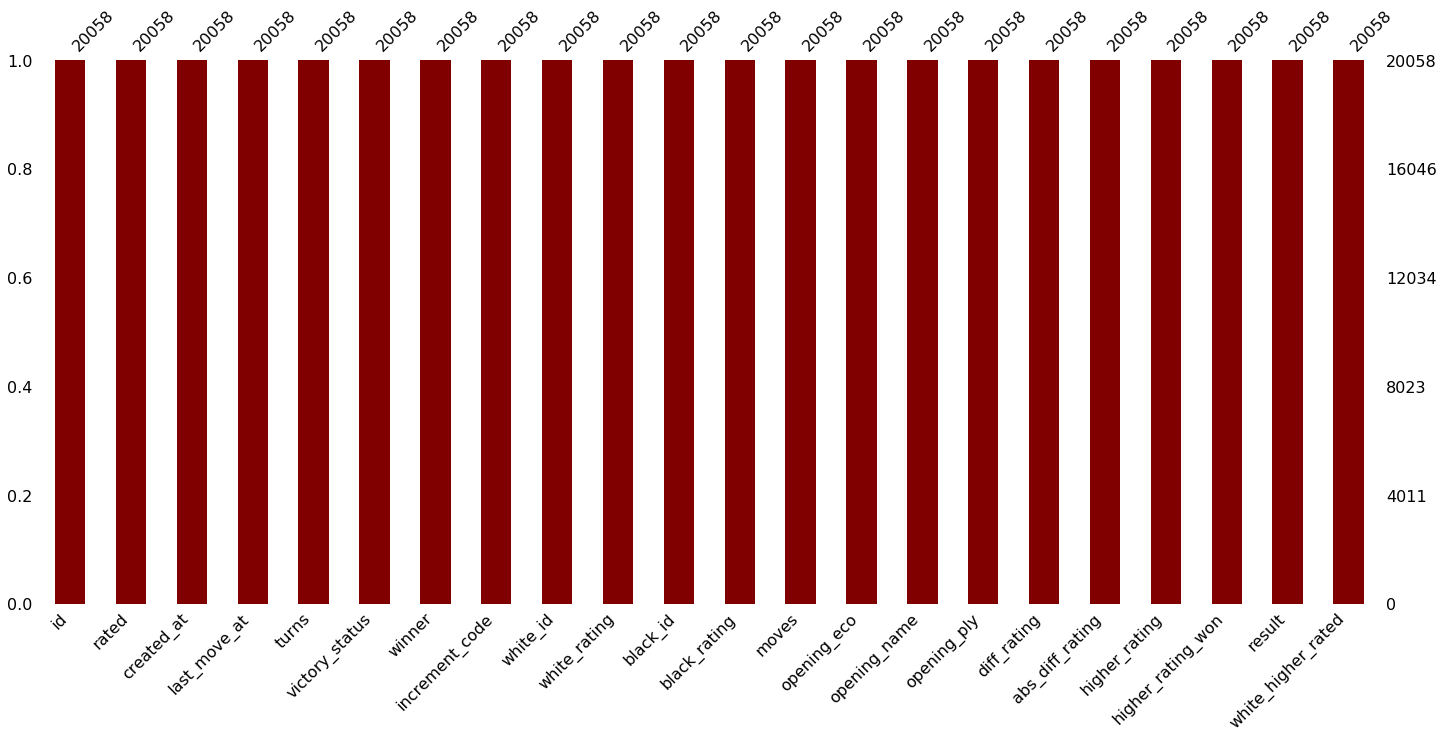

In [14]:
msn.bar(games, color = 'maroon')

This functions gives us a bar plot of the number of complete values in each variable. Incomplete values get signalled by a bar not reaching the 1.0 roof. Since all bars reach 1.0,  we can easily tell no missing values are in the set. In other words, no NA's coded by numpy are found in the dataset. 

## Exploratory Data Analysis

In this section, we examine the variables of interest in our dataset more closely.

In [15]:
import seaborn as sns

In [16]:
sns.set_style("dark")

### Absolute value in differences
We'll start by checking out our abs_diff_rating variable. 

In [17]:
games.abs_diff_rating.describe()

count    20058.000000
mean       173.091435
std        179.214854
min          0.000000
25%         45.000000
50%        115.000000
75%        241.000000
max       1605.000000
Name: abs_diff_rating, dtype: float64

A brief look at the read out lets us know most of our variables (the third quantile) had an absolute difference of 241 points. 
The max rating of 1605 smells suspiciously like an outlier. Below, we can see a histogram of this distribution. 

Text(0.5, 0, 'Absolute Value Difference in Rating')

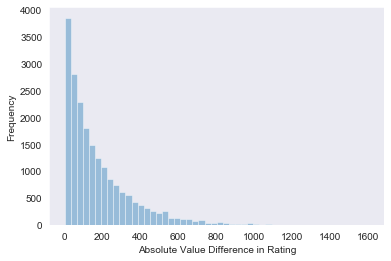

In [18]:
sns.distplot(games.abs_diff_rating,
                        kde=False)
plt.ylabel('Frequency')
plt.xlabel('Absolute Value Difference in Rating')

We can see we've got a one tailed right skewed distribution of absolute values in rating. This also shows graphically how most matches took place between players ratted 200 or less. 

A box plot also helps us visualize possible outliers.

Text(0.5, 0, 'Absolute Value Difference in Rating')

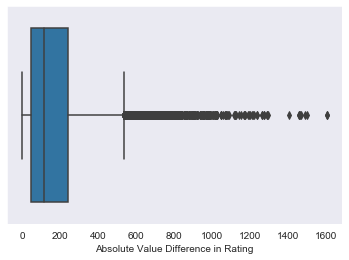

In [19]:
sns.boxplot(x="abs_diff_rating", data=games)
plt.xlabel('Absolute Value Difference in Rating')

It looks like after the 580 absolute value difference, we have many upper outliers. We need not, however, remove them yet since they could inform how large differences contribute to percentages of winning. Note that we don't have low outliers since all of our values are positive. 

Let's find out how many of these upper outliers we have.

In [20]:
# We use the boxplot definition of outliers inline with our plot above.
quartiles = np.percentile(games.abs_diff_rating, [25, 50, 75])
upper_cutoff = games.abs_diff_rating.mean() + 1.5 * ( quartiles[2] - quartiles[0] ) 

In [21]:
np.round(upper_cutoff)

467.0

Our upper cutoff tells us that any game having an absolute difference greater than 467 can be consider an outlier. 

In [22]:
games.loc[games.abs_diff_rating > upper_cutoff, 'abs_diff_rating']

7        695
11       486
12       555
20       582
26       746
        ... 
19921    771
20012    768
20041    507
20042    494
20053    471
Name: abs_diff_rating, Length: 1491, dtype: int64

So, we have 1461 outliers.

I'm curious. Do these big differences in rating have a high proportion of wins for the higher rated player? 

In [23]:
games.loc[games.abs_diff_rating > upper_cutoff, 'higher_rating_won'].value_counts()

1    1257
0     234
Name: higher_rating_won, dtype: int64

Recall that a value of 1 means the higher rated player won, 0 if they drew or lost. Thus, we can interpret this as saying that in these outlier games, 1257 matches resulted in a win for the higher rated player, while 234 of those matches resulted in a loss. As a proportion, we have:

In [24]:
games.loc[games.abs_diff_rating > upper_cutoff, 'higher_rating_won'].value_counts(1)

1    0.843058
0    0.156942
Name: higher_rating_won, dtype: float64

Deciding to keep the outliers depends on the kind of model we use. So, for the moment, we will leave the outliers in the dataset.

### Victory status
We will now take a look at the frequency for victory status. 

Text(0.5, 0, 'Victory Statues')

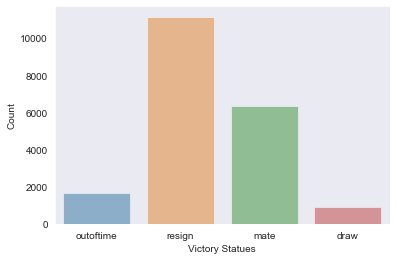

In [25]:
sns.countplot(x = 'victory_status', data = games, alpha = 0.5)
plt.ylabel('Count')
plt.xlabel('Victory Statues')

Most players resigned before being submitted to the shame of a mate. Note how very little draws there are proportionate to the other results. 

When I've played online, I've sometimes beat a better player by having them run out of time. I wonder what we can say about the proportion of wins by a lower rated player due to running out of time. 

In [26]:
victory_group = games.victory_status.groupby(games.higher_rating_won)

In [27]:
victory_group.value_counts(1)

higher_rating_won  victory_status
0                  resign            0.516091
                   mate              0.276668
                   draw              0.117571
                   outoftime         0.089670
1                  resign            0.580473
                   mate              0.339459
                   outoftime         0.080068
Name: victory_status, dtype: float64

The first number (0 or 1) lets us know if the higher rating won. If we look at 0, in other words, the higher rating lost, the outoftime percentage is 0.08967. This is only slightly higher for when the higher rating won at 0.080068. 

### Higher Rating Won

We are interested in checking out how often the higher rating won since this will be one of our response variables in our predictions. 

Text(0.5, 0, 'Higher Rating Won')

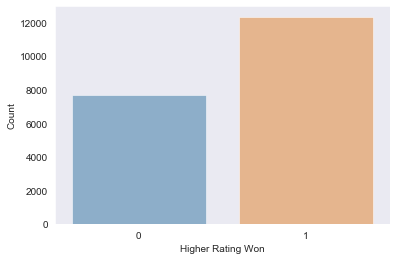

In [28]:
sns.countplot(x = 'higher_rating_won', data = games,  alpha = 0.5)
plt.ylabel('Count')
plt.xlabel('Higher Rating Won')

Below is a specific numerical proportion.

In [29]:
games.higher_rating_won.value_counts(1)

1    0.615814
0    0.384186
Name: higher_rating_won, dtype: float64

So 61% of the time, the higher rating won. 

### Number of turns

We also check out the distribution for the number of turns taken. 

Text(0.5, 0, 'Turns')

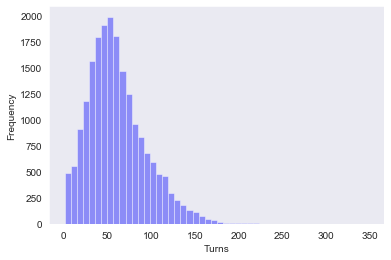

In [30]:
sns.distplot(games.turns, kde = False, color = 'b')
plt.ylabel('Frequency')
plt.xlabel('Turns')

Looks like most turns hover around 50. A numerical distribution is shown below.

In [31]:
games.turns.describe()

count    20058.000000
mean        60.465999
std         33.570585
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64

We get a mean and a median that are similar at 60.46 (so 60 turns) and 55 respectively. Seeing 349 for a max number of turns makes me curious. What more can I say about that match?

In [32]:
games.iloc[games.turns.max()]

id                                                             2icRDIZI
rated                                                              True
created_at                                                  1.50394e+12
last_move_at                                                1.50394e+12
turns                                                               120
victory_status                                                     mate
winner                                                            black
increment_code                                                     10+0
white_id                                                       bomardan
white_rating                                                       1589
black_id                                                          tfeng
black_rating                                                       1569
moves                 d4 Nf6 c4 g6 Nc3 d5 Nf3 Bg7 Bf4 O-O Nb5 c6 Nc7...
opening_eco                                                     

The players had similar ratings of 1589 (white) and 1569 (black), although black ended up winning via mate. 

Don't know if you saw this, but we had a minimum of 1 for turns (look out our output for numerical description of turn data). This is alarming since such games would probably not provide useful information in our models. 

We need to come up with a cut off for how many turns is acceptable in our set. In chess, the fastest check mate is called the Fool's Mate and can happen in two turns. So a cut off of two turns might be acceptable for a realistic match. This, however, happens rarely, so we will instead be conservative and place 10 arbitrarily as our threshold. Since most of our games  were around 55 to 60 moves, (mode of 55 and mean of 60) removing games with less than 10 turns would be helpful. Firstly, because there would probably be very few matches that were truly lost in 10 moves, and secondly, because many games that were not reasonable in nature (e.g. a player resigns because they need to go to the restroom) get removed. 

So, let's remove games with less than 10 turns from our data. 

In [33]:
games.drop(games[games.turns < 10].index, inplace = True)

### Result 

Let's look at the result variable. Recall that this variable encodes whether the higher rated player lost (0), drew (1), or won (2). 

Text(0.5, 0, 'Result')

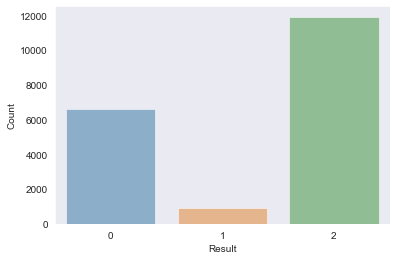

In [34]:
sns.countplot(x = 'result', data = games, alpha = 0.5)
plt.ylabel('Count')
plt.xlabel('Result')

This reflects our victory status variable. For the higher rated player, we have mostly wins (2), a little more than half of these are losses (0), and a small proportion turn out to be draws (1). We can see numerical proportions below.

In [35]:
games.result.value_counts(1)

2    0.612829
0    0.340157
1    0.047014
Name: result, dtype: float64

The higher rated player won 61% of the time, lost 34% of the time, and drew about 5% of the time.

### Increment code 
You have noticed a variable called increment code. 

In [36]:
games.increment_code

0         15+2
1         5+10
2         5+10
3         20+0
4         30+3
         ...  
20053    10+10
20054     10+0
20055     10+0
20056     10+0
20057     10+0
Name: increment_code, Length: 19441, dtype: object

This variable gives us how much each player will receive in rating increase after a match is finished. Intuitively, if a high rated player beats a lower rated player, the higher rated player would receive a few points. But, if the lower rated player beat the higher rated player, they would probably receive a higher amount of points. A draw could result in players receiving the same increment. 

I sound like an expert in this variable, but I'm not. It's my guess. Let's see if my guess holds. To do so, we will check drawed games and see if the increment is equal. 

In [37]:
games.loc[games.victory_status == 'draw', 'increment_code']

40       20+25
98        15+0
126      15+15
143      15+15
181       15+5
         ...  
20003    30+30
20004    30+30
20011    45+45
20014    45+45
20034    45+45
Name: increment_code, Length: 870, dtype: object

So the increment isn't always equal. But this makes sense since a lower rated player could draw with a higher rated player and deserve to be elevated. 

A potential rabbit hole for us to jump is figuring out how an increment code is determined based on result and difference in rating. But we'll leave that for another bedtime story. 

### Exploratory Data Analysis Summary

1) We need not worry about low outliers in the absolute value of differences between ratings. High outliers, however, do exist (according to our definition of boxplot outliers), and we will deal with them based on the model we apply to the data. 

2) For the higher rated player, most of the games end up as wins ~61%, then losses ~34% with a majority of resignations, instead of checkmates. A small percentage of the matches are draws ~5%. 

3) The turns variable revealed short turn games, and we removed any matches that had less than 10 turns. 

4) An interesting study would be to determine how increment codes are decided. 

Since we removed turns outliers from the data, we will re-write out the dataset for later use. 

In [38]:
games.to_csv('games_new_vars.csv')